##  $$\color{blue}{\text{2.131: Artificial Muscle}} $$

#### <center> HH, 9 May 2023

Version Notes:  
-  9 May 2023 Started from StepMotor code, added Potentiometer and Load Cell codes
- 11 May 2023 Tried to add frequency sweep from Digilent SDK (should it instead be a direct looping call to AnalogOut_Sine? How long does each freq need to run?)
- 12 May 2023 Debugging, Confirmed frequency output
- 13 May 2023 fixed sampling frequency and stopped digilent output after test

***

#### Objectives

Notes from Michael:
-map displacement to load/vice versa, calculate gain/phase/transfer function for dif freq.s (can try to fit second order model to transfer function)
-try 100 freq.s (call digilent with SDK python examples)
-define in terms of mechanical impedance vs freq.
-any sense of what mech impedance to expect for 

-drive a geared step motor (see https://www.omc-stepperonline.com/download/17HS13-0404S-PG5.pdf ) to desired position or until desired force condition

-input waveform to LFA

-read position from potentiometer

-read load from load cell

stepper is driven by a TinkerForge step motor controller (called the TinkerForge Silent Stepper Bricklet (see https://www.tinkerforge.com/en/doc/Hardware/Bricklets/Silent_Stepper_V2.html ) or the TinkerForge Silent Stepper Brick (see https://www.tinkerforge.com/en/doc/Hardware/Bricks/Silent_Stepper_Brick.html ) and powered by DeWalt 20V battery.
Waveform is delivered from Digilent to amplifier to LFA.
Potentiometer is read by bricklet (Industrial Dual Analog In).
Load cell is read by load cell bricklet.

#### Import Standard Libraries

In [1]:
import numpy as np # works with complex but one of the arguments must be complex
import matplotlib.pyplot as plt
import time
from scipy import stats
from digilent import discovery

%matplotlib inline
#%config InlineBackend.figure_format = 'png' # use 'png' instead of 'svg' when converting to HTML for assignment submission
%config InlineBackend.figure_format = 'svg' # this is key to improving plot resolution

#### Setup Devices

In [2]:
# Only need to do this after a JupyterLab upgrade
#!pip install tinkerforge

In [3]:
HOST = "localhost"
PORT = 4223
UID_SS = "21bZ" # Change XYZ to the UID of your Silent Stepper Bricklet
UID = "LZv" # Change XYZ to the UID of your Industrial Dual Analog In Bricklet 2.0
UID_LC = "Kin" # Change XYZ to the UID of your Load Cell Bricklet 2.0

from tinkerforge.ip_connection import IPConnection
from tinkerforge.bricklet_silent_stepper_v2 import BrickletSilentStepperV2
#from tinkerforge.brick_silent_stepper import BrickSilentStepper
from tinkerforge.bricklet_industrial_dual_analog_in_v2 import BrickletIndustrialDualAnalogInV2
from tinkerforge.bricklet_load_cell_v2 import BrickletLoadCellV2
from datetime import datetime
from csv import writer

from ctypes import *
from dwfconstants import *
import sys

ipcon = IPConnection() # Create IP connection
# remember to use the TinkerForge viewer to get the UID's of the various devices below (red string)

ss = BrickletSilentStepperV2(UID_SS, ipcon) # Create device object
#ss = BrickSilentStepper(UID_SS, ipcon) # Create device object
idai = BrickletIndustrialDualAnalogInV2(UID, ipcon) # Create device object
lc = BrickletLoadCellV2(UID_LC, ipcon) # Create device object

ipcon.connect(HOST, PORT) # Connect to brickd
time.sleep(1) # Don't use device before ipcon is connected

#settings
idai.set_sample_rate(0)
lc.set_configuration(1,0)
time.sleep(1)
lc.set_moving_average(1)
print(lc.get_moving_average())
print(lc.get_configuration())


1
Configuration(rate=1, gain=0)


In [10]:

if sys.platform.startswith("win"):
    dwf = cdll.dwf
elif sys.platform.startswith("darwin"):
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
else:
    dwf = cdll.LoadLibrary("libdwf.so")

hdwf = c_int()
channel = c_int(0)

version = create_string_buffer(16)
dwf.FDwfGetVersion(version)
print("DWF Version: "+str(version.value))

# prevent temperature drift
dwf.FDwfParamSet(DwfParamOnClose, c_int(1)) # 0 = run, 1 = stop, 2 = shutdown

#open device
print("Opening first device...")
dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))


if hdwf.value == hdwfNone.value:
    print("failed to open device")
    quit()

DWF Version: b'3.19.25'
Opening first device...



Don't forget to calibrate load cell and potentiometer (convert voltage to position)

#### Run Frequency Sweep Experiment

In [ ]:
Load_file = datetime.now().strftime('Load-%Y-%m-%d-%H-%M-%S.csv')
Pos_file = datetime.now().strftime('Pos-%Y-%m-%d-%H-%M-%S.csv')

# Callback function for weight callback
def cb_weight(weight):
    with open(Load_file, 'a') as f_object_load:
        writer_object_load = writer(f_object_load)
        writer_object_load.writerow([datetime.now().strftime('%H:%M:%S:%f'),weight])
        f_object_load.close()
        #print("Weight: " + str(weight) + " g")
        
# Callback function for voltage callback
def cb_voltage(channel, voltage):
    with open(Pos_file, 'a') as f_object_pos:
        #insert voltage to position conversion
        writer_object_pos = writer(f_object_pos)
        writer_object_pos.writerow([datetime.now().strftime('%H:%M:%S:%f'),voltage])
        f_object_pos.close()
        #print("Voltage: " + str(voltage/1000.0) + " V")
        
# Set period for weight callback to 12ms without a threshold
lc.set_weight_callback_configuration(12, False, "x", 0, 0)
print(lc.get_configuration())
# Callback
lc.register_callback(lc.CALLBACK_WEIGHT, cb_weight)

# Set period for voltage (channel 0) callback to 12ms without a threshold
idai.set_voltage_callback_configuration(0, 12, False, "x", 0, 0)
# Register voltage callback to function cb_voltage
idai.register_callback(idai.CALLBACK_VOLTAGE, cb_voltage)

freq_min = 2 #Hz
freq_max = 40
n = 39 # number of frequencies
amp = 0.115 # V
offset = -0.18

f = np.linspace(freq_min,freq_max,n)
j = 0

# 0 = the device will be configured only when calling FDwf###Configure
dwf.FDwfDeviceAutoConfigureSet(hdwf, c_int(0))

dwf.FDwfAnalogOutNodeEnableSet(hdwf, channel, AnalogOutNodeCarrier, c_int(1))
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, channel, AnalogOutNodeCarrier, funcSine)
dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, channel, AnalogOutNodeCarrier, c_double(amp))
dwf.FDwfAnalogOutNodeOffsetSet(hdwf, channel, AnalogOutNodeCarrier, c_double(offset))

while j<len(f):
    dwf.FDwfAnalogOutNodeFrequencySet(hdwf, channel, AnalogOutNodeCarrier, c_double(f[j]))

    print("Generating sine wave...freq: "+str(f[j])+" Hz")
    dwf.FDwfAnalogOutConfigure(hdwf, channel, c_int(1))

    time.sleep(10/f[j]) # wait until 10 samples can be acquired
    j = j+1

dwf.FDwfDeviceClose(hdwf)
input("Press key to exit\n") # Use raw_input() in Python 2
ipcon.disconnect()

#### Set Stepper Parameters

In [ ]:
# Step motors have 200 marco steps/rev
# the gear box is 5.18:1 which means that the step motor has to rotate 5.18 revs to produce 1 rev of gear box output shaft
ss.set_motor_current(800) # 800 mA
ss.set_step_configuration(ss.STEP_RESOLUTION_128, True) # 128 micro-steps (usteps) per macro step
# 128 * 200 usteps per rev = 25,600 usteps/rev
ss.set_max_velocity(10000) # Velocity 1,280 * 5.18 usteps/s = 0.05 rev /s of gear box output shaft
# max velocity is 2**16-1 = 65,535
ss.set_speed_ramping(0,0) # max accel and decel

ss.set_enabled(False) # Disable motor power
#ss.enable() # Enable motor power

#### Run Tensile Test

In [ ]:
F_file = datetime.now().strftime('F-%Y-%m-%d-%H-%M-%S.csv')
D_file = datetime.now().strftime('F-%Y-%m-%d-%H-%M-%S.csv')

# Callback function for weight callback
def cb_weight(weight):
    with open(F_file, 'a') as f_object_f:
        writer_object_f = writer(f_object_f)
        writer_object_f.writerow([datetime.now().strftime('%H:%M:%S:%f'),weight])
        f_object_f.close()
        #print("Weight: " + str(weight) + " g")
        
def cb_position_reached(position, ss):
    with open(D_file, 'a') as f_object_d:
        writer_object_d = writer(f_object_d)
        writer_object_d.writerow([datetime.now().strftime('%H:%M:%S:%f'),ss.get_current_position()])
        f_object_d.close()
        #print("Weight: " + str(weight) + " g")
        ss.set_steps(-200)
        

# Set period for weight callback to 12ms without a threshold
lc.set_weight_callback_configuration(12, False, "x", 0, 0)
# Callback
lc.register_callback(lc.CALLBACK_WEIGHT, cb_weight)

# alternatively: run stepper while F > threshold (threshold indicates when fiber breaks)

# Register move callback to function cb_move
ss.register_callback(ss.CALLBACK_POSITION_REACHED,
                         lambda x: cb_position_reached(x, ss))

ss.set_enabled(True) # Enable motor power
ss.set_steps(-1) # Drive one step forward to get things going


input("Press key to exit when fiber has failed\n") # Use raw_input() in Python 2

# Stop motor before disabling motor power
ss.stop() # Request motor stop
ss.set_speed_ramping(0, 0) # Fast deacceleration (5000 steps/s^2) for stopping
time.sleep(0.4) # Wait for motor to actually stop: max velocity (2000 steps/s) / decceleration (5000 steps/s^2) = 0.4 s
ss.set_enabled(False) # Disable motor power

ipcon.disconnect()

#### Generate Gaussian non-white (2-40 Hz) noise input, x

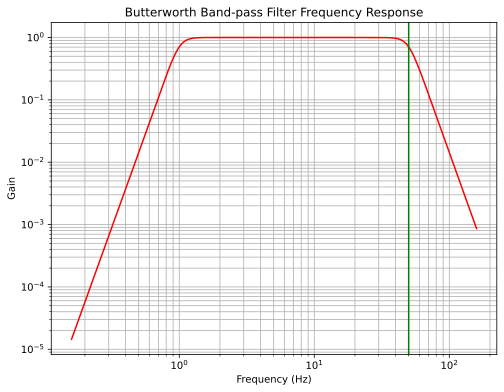

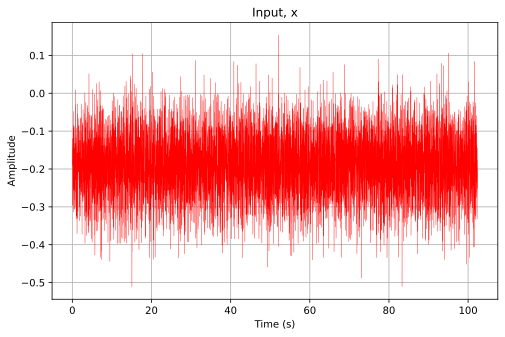

In [4]:
from scipy import signal

samrate=80.0 # sampling rate in samples per second
dt=1/samrate #inter sample interval. 
n=2**13 # total number of samples (make it a power of 2 for efficient use of FFTs)
gw=0.1*np.random.randn(n) # Gaussian white noise with mean = 0 and sd = 1
t=np.arange(0.0, n*dt, dt)

# make butterworth filter
b, a = signal.butter(6,[1*np.pi*2,2*np.pi*50], 'band', analog=True) #low-pass filter design
w, h = signal.freqs(b, a, worN=np.logspace(0, 3, 1000))
plt.rcParams['figure.figsize'] = [8, 6]
plt.loglog(w/(2*np.pi), abs(h),'r')
plt.title('Butterworth Band-pass Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(which='both', axis='both')
plt.axvline(50, color='green') # cutoff frequency
plt.show()

tt,gnw,tmp = signal.lsim((b, a), gw, t)
gnw = gnw-0.19
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
ax.plot(t, gnw, 'r',linewidth=0.4)
ax.set(xlabel='Time (s)', ylabel='Amplitude', title='Input, x')
ax.grid()
plt.show()

#### Run Gaussian input experiment

In [5]:
Fgauss_file = datetime.now().strftime('Fgauss-%Y-%m-%d-%H-%M-%S.csv')
Dgauss_file = datetime.now().strftime('Dgauss-%Y-%m-%d-%H-%M-%S.csv')

# Callback function for weight callback
def cb_weight(weight):
    with open(Fgauss_file, 'a') as f_object_load:
        writer_object_load = writer(f_object_load)
        writer_object_load.writerow([datetime.now().strftime('%H:%M:%S:%f'),weight])
        f_object_load.close()
        #print("Weight: " + str(weight) + " g")
        
# Callback function for voltage callback
def cb_voltage(channel, voltage):
    with open(Dgauss_file, 'a') as f_object_pos:
        #insert voltage to position conversion
        writer_object_pos = writer(f_object_pos)
        writer_object_pos.writerow([datetime.now().strftime('%H:%M:%S:%f'),voltage])
        f_object_pos.close()
        #print("Voltage: " + str(voltage/1000.0) + " V")
        
# Set period for weight callback to 12ms without a threshold
lc.set_weight_callback_configuration(12, False, "x", 0, 0)
print(lc.get_configuration())
# Callback
lc.register_callback(lc.CALLBACK_WEIGHT, cb_weight)

# Set period for voltage (channel 0) callback to 12ms without a threshold
idai.set_voltage_callback_configuration(0, 12, False, "x", 0, 0)
# Register voltage callback to function cb_voltage
idai.register_callback(idai.CALLBACK_VOLTAGE, cb_voltage)

# setup digilent discovery 2: 
ad2 = discovery()
time.sleep(1)

u = gnw

#collect data
try:
    x, y, lost, corrupted = ad2.adda(u, samrate, input_range_1=10.0, input_range_2 = 10.0, output_range=5.0)
    if lost > 0 or corrupted > 0 :
        print('   Num lost data = '+str(lost)+'    Num corrupted data = '+str(corrupted))
except Exception as e:
    print('   Exception:', e)
ad2.close()

Configuration(rate=1, gain=0)
